<a href="https://colab.research.google.com/github/hasibulhshovo/COMP432/blob/main/lab4/lab_4_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\textbf{LAB 04: Logistic Regression}$

## $\Large\textbf{Main Points}$

### $\textit{Topics we will cover:}$

* $\bullet$ Implement logistic regression classifier with sigmoid activation
* $\bullet$ Code gradient descent optimization from scratch  
* $\bullet$ Build the model that outputs probabilities instead of hard decisions
* $\bullet$ Track loss convergence during training
* $\bullet$ Compare performance on training and test data
* $\bullet$ Example using sklearn's LogisticRegression

---

For visualization of gradient descent: [Gradient Descent Visualizer](https://www.deeplearning.ai/ai-notes/optimization/) (Near the end of the page)

---


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler


## $\textbf{The Dataset: Tumor Classification}$

We use breast cancer data predicting whether a tumor is malignant based on:

* $\textbf{Tumor Radius}$: Size of the tumor (normalized)
* $\textbf{Tumor Texture}$: Roughness measurement (normalized)
* $\textbf{Target}$: Binary classification - Benign (1) / Malignant (0)


---

# Part 1: Data loading

In [2]:
data = load_breast_cancer() # breast cancer dataset from sklearn

# here we will only use first 2 features

X = data.data[:, [0, 1]]  # radius and texture
y = data.target  # 1 = benign, 0 = malignant

# create dataframe
df = pd.DataFrame(X, columns=['radius', 'texture'])
df['diagnosis'] = y

print(df.head())
print(f"Dataset shape: {df.shape}")
print(f"Benign samples: {(y == 1).sum()}")
print(f"Malignant samples: {(y == 0).sum()}")

# Normalization, note from last lab, we also went over the effect of this on the model's result
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / X_std

print(f"Feature dimensions: {X_normalized.shape}")
print(f"Number of samples: {len(y)}")

   radius  texture  diagnosis
0   17.99    10.38          0
1   20.57    17.77          0
2   19.69    21.25          0
3   11.42    20.38          0
4   20.29    14.34          0
Dataset shape: (569, 3)
Benign samples: 357
Malignant samples: 212
Feature dimensions: (569, 2)
Number of samples: 569


# Part 2: Implement Logistic Regression

### Logistic Regression
The model outputs probability using sigmoid function:

$p = \sigma(\theta^T X + \theta_0) = \frac{1}{1 + e^{-(\theta^T X + \theta_0)}}$

where sigmoid squashes any value to range (0, 1)

In [3]:
class LogisticRegression:

    def __init__(self, learning_rate=0.1, n_iterations=300):
        # Initialize the learning rate and number of iterations for gradient descent
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

        # Model parameters (weights and bias) to be initialized later
        self.theta = None     # Weights
        self.theta0 = None    # Bias (intercept)

        # To store loss after each iteration (for analysis or plotting)
        self.loss_history = []

    def sigmoid(self, z):
        # Sigmoid activation function: maps input to range (0, 1)
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):  # negative log likelihood
        # Compute the binary cross-entropy loss

        m = len(y)  # Number of samples
        z = X.dot(self.theta) + self.theta0  # Linear combination of features and weights
        predictions = self.sigmoid(z)  # Predicted probabilities

        epsilon = 1e-7  # Small constant to avoid log(0)
        predictions = np.clip(predictions, epsilon, 1 - epsilon)  # Clipping predictions

        # Compute average negative log-likelihood (cross-entropy loss)
        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return loss

    def fit(self, X, y):
        # Fit the model to the training data using gradient descent

        n_samples, n_features = X.shape

        # Initialize weights (theta) with small random values and bias (theta0) as zero
        self.theta = np.random.randn(n_features) * 0.01
        self.theta0 = 0

        # Gradient descent loop
        for iteration in range(self.n_iterations):
            # Forward pass: compute predicted values
            z = X.dot(self.theta) + self.theta0
            predictions = self.sigmoid(z)

            # Compute and store the loss
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

            # Compute gradients w.r.t. weights and bias
            errors = predictions - y
            grad_theta = (1 / n_samples) * X.T.dot(errors)
            grad_theta0 = (1 / n_samples) * np.sum(errors)

            # Update model parameters using gradient descent
            self.theta -= self.learning_rate * grad_theta
            self.theta0 -= self.learning_rate * grad_theta0

            # Optionally print the loss every 50 iterations
            if iteration % 50 == 0:
                print(f"  Iteration {iteration}: Loss = {loss:.3f}")

        return self  # Return the fitted model instance

    def predict_proba(self, X):
        # Return the predicted probabilities (between 0 and 1)
        z = X.dot(self.theta) + self.theta0
        return self.sigmoid(z)

    def predict(self, X):
        # Predict binary class labels (0 or 1) based on probability threshold of 0.5
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        # Compute accuracy: proportion of correct predictions
        predictions = self.predict(X)
        return np.mean(predictions == y)

# Part 3: Train and Evaluate

In [4]:
# Split the normalized feature matrix and target vector into training and test sets
# test_size=0.3 means 30% of the data is used for testing, and 70% for training
# random_state=42 ensures reproducibility (same split every time the code runs)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Print the number of training samples
print(f"Training samples: {len(X_train)}")

# Print the number of test samples
print(f"Test samples: {len(X_test)}")

Training samples: 398
Test samples: 171


In [5]:
# Define a list of different learning rates to experiment with
learning_rates = [0.01, 0.1, 1.0, 5.0]

# List to store performance metrics for each learning rate
results = []

# Initialize variables to keep track of the best model and highest test accuracy
best_model = None
best_accuracy = 0

# Loop through each learning rate
for lr in learning_rates:
    print(f" going over with learning rate = {lr}")

    # Create a new LogisticRegression model instance with the current learning rate
    model = LogisticRegression(learning_rate=lr, n_iterations=200)

    # Train the model using the training data
    model.fit(X_train, y_train)

    # Evaluate the model's accuracy on training data
    train_acc = model.score(X_train, y_train)

    # Evaluate the model's accuracy on test data
    test_acc = model.score(X_test, y_test)

    # Store the results (learning rate, accuracies, and final loss value)
    results.append({
        'learning_rate': lr,
        'train_acc': train_acc * 100,   # convert to percentage
        'test_acc': test_acc * 100,     # convert to percentage
        'final_loss': model.loss_history[-1]  # last loss value after training
    })

    # Update best model if this one performs better on the test set
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = model
        best_lr = lr

    # Print training and test accuracy for the current model
    print(f"Training accuracy: {train_acc:}")
    print(f"  Test accuracy: {test_acc:}")

 going over with learning rate = 0.01
  Iteration 0: Loss = 0.692
  Iteration 50: Loss = 0.618
  Iteration 100: Loss = 0.563
  Iteration 150: Loss = 0.521
Training accuracy: 0.8793969849246231
  Test accuracy: 0.8888888888888888
 going over with learning rate = 0.1
  Iteration 0: Loss = 0.694
  Iteration 50: Loss = 0.388
  Iteration 100: Loss = 0.333
  Iteration 150: Loss = 0.312
Training accuracy: 0.8844221105527639
  Test accuracy: 0.9064327485380117
 going over with learning rate = 1.0
  Iteration 0: Loss = 0.692
  Iteration 50: Loss = 0.282
  Iteration 100: Loss = 0.278
  Iteration 150: Loss = 0.278
Training accuracy: 0.8894472361809045
  Test accuracy: 0.9064327485380117
 going over with learning rate = 5.0
  Iteration 0: Loss = 0.697
  Iteration 50: Loss = 0.278
  Iteration 100: Loss = 0.278
  Iteration 150: Loss = 0.278
Training accuracy: 0.8894472361809045
  Test accuracy: 0.9064327485380117


# Part 4: Visualize the results

In [6]:
results_df = pd.DataFrame(results)
print(results_df)

   learning_rate  train_acc   test_acc  final_loss
0           0.01  87.939698  88.888889    0.489054
1           0.10  88.442211  90.643275    0.300520
2           1.00  88.944724  90.643275    0.277936
3           5.00  88.944724  90.643275    0.277924


  Iteration 0: Loss = 0.687
  Iteration 50: Loss = 0.614
  Iteration 100: Loss = 0.560
  Iteration 150: Loss = 0.519
  Iteration 200: Loss = 0.487
  Iteration 250: Loss = 0.461
  Iteration 0: Loss = 0.696
  Iteration 50: Loss = 0.388
  Iteration 100: Loss = 0.333
  Iteration 150: Loss = 0.311
  Iteration 200: Loss = 0.300
  Iteration 250: Loss = 0.294
  Iteration 0: Loss = 0.697
  Iteration 50: Loss = 0.282
  Iteration 100: Loss = 0.278
  Iteration 150: Loss = 0.278
  Iteration 200: Loss = 0.278
  Iteration 250: Loss = 0.278
  Iteration 0: Loss = 0.691
  Iteration 50: Loss = 0.278
  Iteration 100: Loss = 0.278
  Iteration 150: Loss = 0.278
  Iteration 200: Loss = 0.278
  Iteration 250: Loss = 0.278


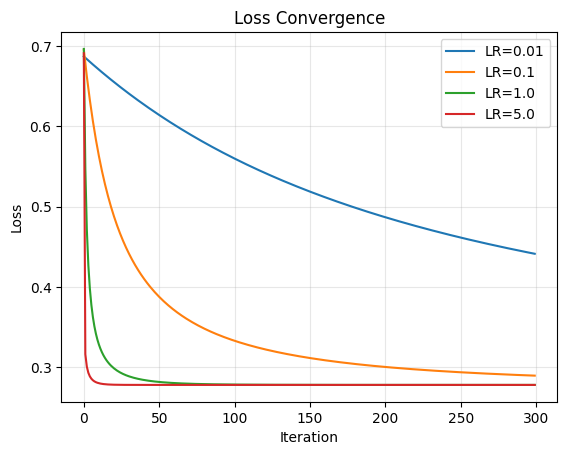

In [7]:
# Loop through the first 4 learning rates to train models and plot their loss curves
for i, lr in enumerate(learning_rates[:4]):  # Plotting loss curves for first 4 learning rates
    # Create a new model instance with the current learning rate
    model = LogisticRegression(learning_rate=lr, n_iterations=300)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Plot the loss history for this learning rate
    plt.plot(model.loss_history, label=f'LR={lr}')

# Add labels and title to the plot
plt.xlabel('Iteration')             # X-axis: number of iterations
plt.ylabel('Loss')                  # Y-axis: loss value
plt.title('Loss Convergence')       # Plot title

# Show legend to distinguish between different learning rates
plt.legend()

# Add a light grid to the plot for better readability
plt.grid(alpha=0.3)

# Part 6: Analyzing Predictions
This is a simple confidence check, the goal from this is to get the least confident and the most confident predictions


In [8]:
# Get the predicted probabilities for the test set using the best model
test_probs = best_model.predict_proba(X_test)  # Each value is the predicted probability of class 1

# Calculate confidence scores: distance from 0.5, scaled to range [0, 1]
# A probability of 0.5 means total uncertainty; closer to 0 or 1 means higher confidence
confidence = np.abs(test_probs - 0.5) * 2

# Find the index of the most confident prediction (highest confidence value)
most_confident = np.argmax(confidence)

# Find the index of the least confident prediction (lowest confidence value)
least_confident = np.argmin(confidence)

# Print the probability of the most confident prediction
print(f"Most confident: P={test_probs[most_confident]:.2f}")

# Print the probability of the least confident prediction
print(f"Least confident: P={test_probs[least_confident]:.2f}")

Most confident: P=0.00
Least confident: P=0.50


# Part 7: Sklearn

In [9]:
# Import scikit-learn's built-in LogisticRegression model
from sklearn.linear_model import LogisticRegression as SklearnLogistic

# Create an instance of the sklearn logistic regression model
# max_iter=1000 ensures the model has enough iterations to converge
# random_state=42 makes the results reproducible
sklearn_model = SklearnLogistic(max_iter=1000, random_state=42)

# Train the sklearn model on the training data
sklearn_model.fit(X_train, y_train)

# Evaluate accuracy on the training set
sklearn_train_acc = sklearn_model.score(X_train, y_train)

# Evaluate accuracy on the test set
sklearn_test_acc = sklearn_model.score(X_test, y_test)

# Print training accuracy
print(f"Sklearn - train: {sklearn_train_acc:.2f}")

# Print test accuracy
print(f"Sklearn -  test: {sklearn_test_acc:.2f}")

Sklearn - train: 0.89
Sklearn -  test: 0.91


------------------------

---------------

-------------------


# Task 1: Implement prediction threshold analysis

Hint: Try different thresholds (0.3, 0.5, 0.7) and see how accuracy changes

# Task 2: Add L2 regularization to the model

Hint: Add $\lambda||\theta||^2$ term to the loss and λθ to the gradient

# Task 3: Implement mini-batch gradient descent

Hint: Instead of using all samples, randomly select a batch for each update



-----------------------------------------